<a href="https://colab.research.google.com/github/s-choung/CER_ML/blob/main/CERML_FI_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import 버전들 확인

In [13]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import sklearn
import sys
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate, RepeatedKFold
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm, randint, uniform, rv_continuous
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, Ridge
import shap
from xgboost import XGBRegressor
import xgboost
from pprint import pprint
from matplotlib import font_manager as fm

print('Numpy Version', np.__version__)
print('Pandas Version', pd.__version__)
print('Matplotlib Version', matplotlib.__version__)
print('Scikit-Learn Version', sklearn.__version__)
print('Tensorflow Version', tf.__version__)
print('Python Version', sys.version)

Numpy Version 1.22.4
Pandas Version 1.5.3
Matplotlib Version 3.7.1
Scikit-Learn Version 1.2.2
Tensorflow Version 2.12.0
Python Version 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]


In [15]:
%matplotlib inline

In [16]:
#폰트 크기 조절
'''
import matplotlib 
matplotlib.font_manager._rebuild()
font_path = './segoeui.ttf'
font_prop = fm.FontProperties(fname=font_path)
matplotlib.rcParams['font.family'] = font_prop.get_name()'''

tick_font_size = 15
label_font_size = 20
title_font_size = 20
tick_font_style = fm.FontProperties(fname='./segoeui.ttf',size=tick_font_size) # 폰트는 원하는 폰트로 바꿔주세용
label_font_style = fm.FontProperties(fname='./segoeui.ttf',size=label_font_size)
title_font_style = fm.FontProperties(fname='./segoeui.ttf',size=title_font_size)

#matplotlib.rcParams['font.family'] = 'Comic Sans MS' #이걸 켜보면 모든 폰트가 다 바뀌는 것을 확인 가능
fs = 20 # 타이틀 크기
fss = 15 # xlabel 크기

DATA 읽어오기

# Data preprocessing

['electron_affinity', 'en_pauling', 'period', 'valence electrons', 'metal_d_Center', 'metal_d_Width', 'metal_DOS_d', 'metal_SP_Filling', 'metal_DOS_sp', 'Mean ICOBI value', 'Mean ICOHP value', 'Mean ICOOP value', 'coord_SP_Center', 'coord_SP_Width', 'coord_DOS_SP', 'Nnum']


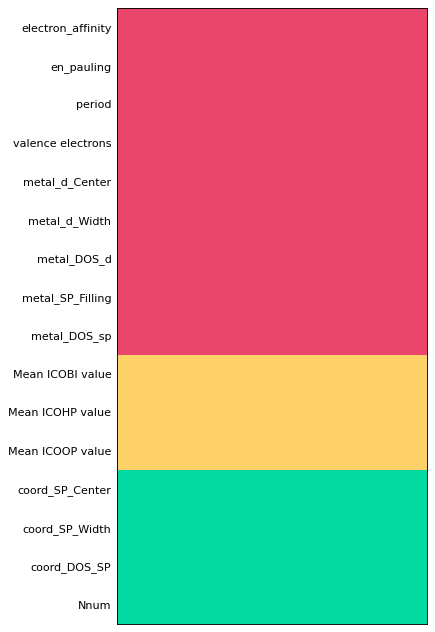

In [56]:
# 훈련 데이터 불러오기

df = pd.read_excel('./ads_final_2.xlsx')
df2=df

# Step 3: 'M' 열 제거
df = df.drop('M', axis=1)  # 'M'은 실제로 해당 열의 이름이어야 합니다.
df = df.drop('index', axis=1)  
# Step 4: 'G_Cl' 열을 예측 변수로 설정
y = df['G(Cl)']  # 'G_Cl'은 실제로 해당 열의 이름이어야 합니다.
X = df.drop('G(Cl)', axis=1)  # 'G_Cl'은 실제로 해당 열의 이름이어야 합니다.
c= ['#EA466C','#FED269','#02DAA2','#00b3fe','#0E8BB3','#120458']

column_names = X.columns.to_list()
print(column_names)
selected_feature_names=X.columns
column_dict = {i:name for i, name in enumerate(column_names)}
# Color 설정

color_a = '#EA466C'
color_b = '#FED269'
color_c = '#02DAA2'

# Create the color list

colors = [color_a]*9 + [color_b]*3 + [color_c]*4 # 앞에서부터 원하는 범위까지 설정해주면 됨.

# 각 feature별로 칼라가 원하는대로 설정됐는지 확인

fig, ax = plt.subplots(1, 1, figsize=(5, 10), dpi=80)

for i, color in enumerate(colors):
    rect = mpatches.Rectangle((0, i), 1, 1, facecolor=color)
    ax.add_patch(rect)

ax.set_xlim(0, 1)
ax.set_ylim(0, len(colors))
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.tick_params(axis='x', which='both', bottom=False, top=False)

ax.set_yticks([i + 0.5 for i in range(len(colors))], minor=True)
ax.set_yticklabels(column_names, minor=True)
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.tick_params(axis='y', which='both', left=False, right=False)
ax.invert_yaxis()
plt.show()

feature_colors = {name: color for name, color in zip(selected_feature_names, colors)}

In [18]:
print(X)

    electron_affinity  en_pauling  period  valence electrons  metal_d_Center  \
0           -0.500000        1.55       4                  7           -0.91   
1            0.151000        1.83       4                  8           -0.72   
2            0.662256        1.88       4                  9           -1.37   
3            1.156000        1.91       4                 10           -1.36   
4            1.235000        1.90       4                 11           -2.64   
..                ...         ...     ...                ...             ...   
67           1.302000        1.93       5                 11           -4.81   
68           1.563800        2.20       6                  9           -0.32   
69           2.128000        2.20       6                 10           -1.57   
70           2.308630        2.40       6                 11           -4.20   
71           0.666000        1.66       4                  6            1.25   

    metal_d_Width  metal_DOS_d  metal_S

여기서부터 Supervised Learning Part (SVM, Randomforest, NN)

Training set 나누기!

In [19]:


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)  # 적당한 비율로 training과 test set을 나누는 부분

# Feature Importance Search

Data Scaling

In [20]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)
x_scaled = scaler.fit_transform(X)
x_train_scaled_df = pd.DataFrame(x_train_scaled, columns=x_train.columns)
x_test_scaled_df = pd.DataFrame(x_test_scaled, columns=x_test.columns)

Permutation functions 선언

In [21]:
def get_score_after_permutation(model, X, y, curr_feat):
    """ return the score of model when curr_feat is permuted """

    X_permuted = X.copy()
    col_idx = list(X.columns).index(curr_feat)
    # permute one column
    X_permuted.iloc[:, col_idx] = np.random.permutation(
        X_permuted[curr_feat].values)

    permuted_score = model.score(X_permuted, y)
    return permuted_score


def get_feature_importance(model, X, y, curr_feat):
    """ compare the score when curr_feat is permuted """

    baseline_score_train = model.score(X, y)
    permuted_score_train = get_score_after_permutation(model, X, y, curr_feat)

    # feature importance is the difference between the two scores
    feature_importance = baseline_score_train - permuted_score_train
    return feature_importance

def permutation_importance(model, X, y, n_repeats=10):
    """Calculate importance score for each feature."""

    importances = []
    for curr_feat in X.columns:
        list_feature_importance = []
        for n_round in range(n_repeats):
            list_feature_importance.append(
                get_feature_importance(model, X, y, curr_feat))

        importances.append(list_feature_importance)

    return {'importances_mean': np.mean(importances, axis=1),
            'importances_std': np.std(importances, axis=1),
            'importances': importances}

def plot_feature_importances(perm_importance_result, feat_name):
    """ bar plot the feature importance """

    fig, ax = plt.subplots()

    indices = perm_importance_result['importances_mean'].argsort()

    sorted_colors = [feature_colors[name] for name in selected_feature_names[indices]]
    
    plt.barh(range(len(indices)),
             perm_importance_result['importances_mean'][indices],
             xerr=perm_importance_result['importances_std'][indices], color=sorted_colors)

    ax.set_yticks(range(len(indices)))
    _ = ax.set_yticklabels(feat_name[indices])

Data 분포 정의 for alpha values

In [22]:
class CustomExpNormal(rv_continuous):
    def __init__(self, mean, std):
        super().__init__()
        self.mean = mean
        self.std = std

    def _pdf(self, x):
        norm_factor = 1.0 / (self.std * np.sqrt(2 * np.pi))
        exponent = -0.5 * ((np.log(np.maximum(1e-10, x)) - self.mean) / self.std)**2

        valid_indices = x > 0
        pdf = np.zeros_like(x)
        pdf[valid_indices] = norm_factor * np.exp(exponent[valid_indices])

        return pdf

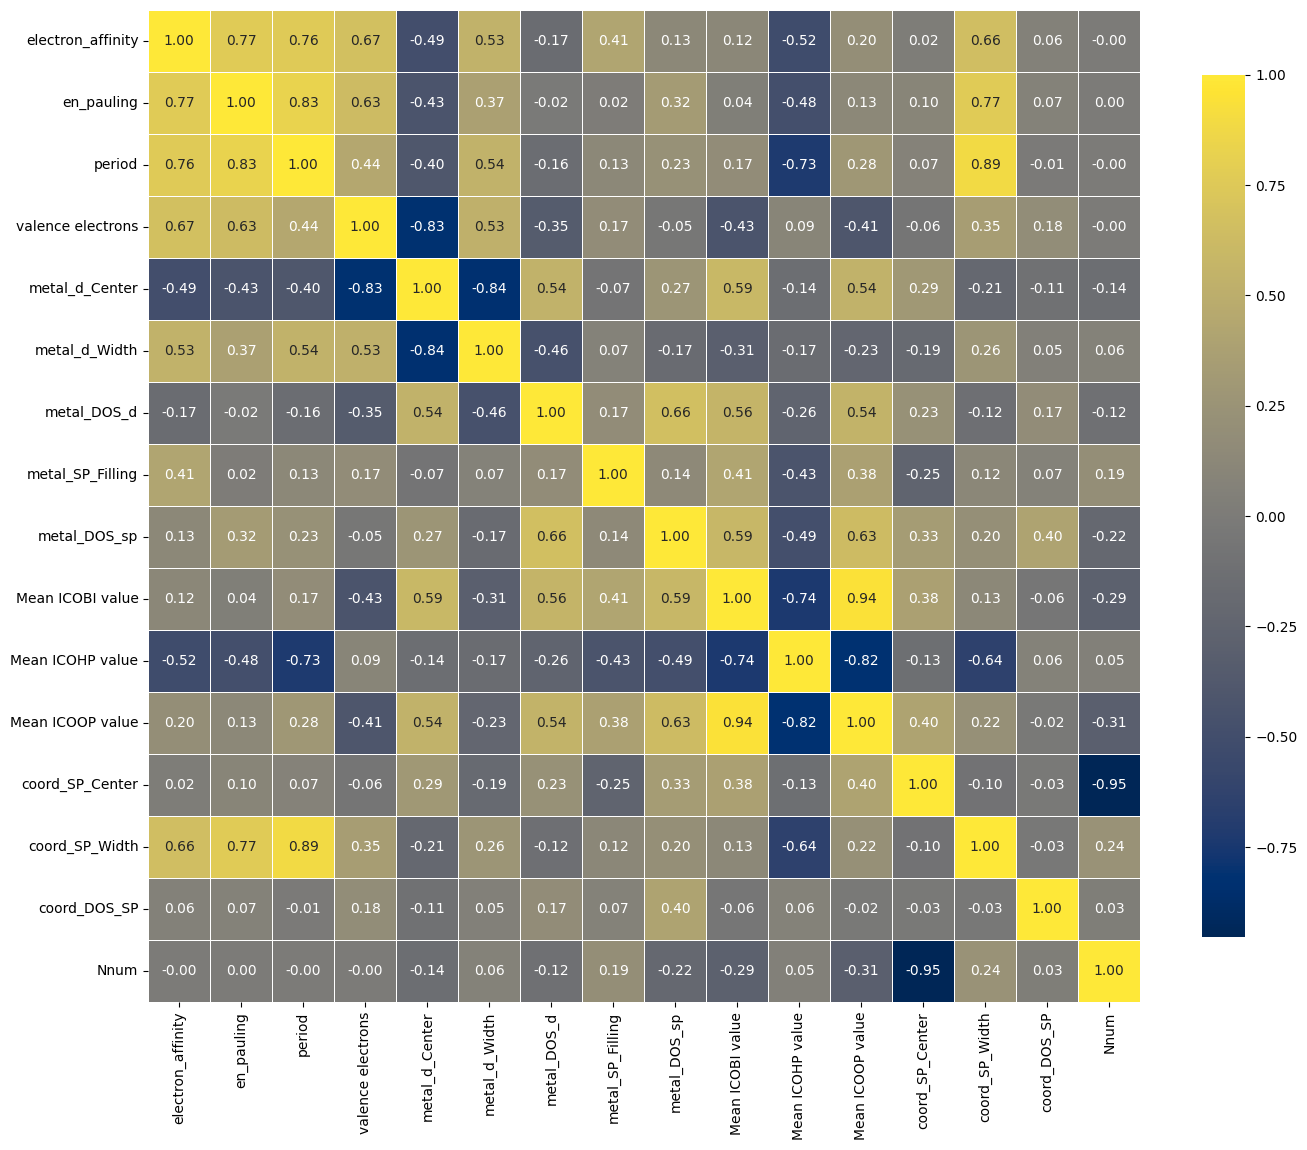

In [23]:

def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(16,16))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="cividis",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )
    plt.savefig('./corr.png', bbox_inches = 'tight')
    plt.show()

correlation_heatmap(X[selected_feature_names])


### 3. RandomForest 기반 Feature importance

In [24]:
'''n_estimators = randint(100, 1000)

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

min_samples_split = [2, 5, 7, 10]

min_samples_leaf = [1, 2, 3, 4]

bootstrap = [True, False]

params_rf = {'n_estimators': n_estimators,
             'max_depth': max_depth,
             'min_samples_split': min_samples_split,
             'min_samples_leaf': min_samples_leaf,
             'bootstrap': bootstrap}
pprint(params_rf)'''

from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

n_estimators = sp_randint(100, 500) # Reduced the upper limit

max_depth = [int(x) for x in np.linspace(10, 50, num = 5)] # Reduced the number of options and the maximum depth
max_depth.append(None)

min_samples_split = [2, 5, 10] # Removed 7 to reduce the options

min_samples_leaf = [1, 2, 4] # Removed 3 to reduce the options

bootstrap = [True, False]

params_rf = {'n_estimators': n_estimators,
             'max_depth': max_depth,
             'min_samples_split': min_samples_split,
             'min_samples_leaf': min_samples_leaf,
             'bootstrap': bootstrap}

pprint(params_rf)

rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = params_rf, 
                               n_iter = 100, cv = 5, verbose=2, random_state=42, 
                               n_jobs = -1, scoring='neg_mean_squared_error')

rf_random.fit(x_train, y_train)

print("Best parameters found: ", rf_random.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(rf_random.best_score_)))


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f1a196b7a00>}
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'bootstrap': True, 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 286}
Lowest RMSE found:  0.26346862682739247


In [25]:
# 최적의 모델 및 파라미터 출력

best_rf = rf_random.best_estimator_

print("Best Estimator:", rf_random.best_params_)

print('Score on training set:', best_rf.score(x_train, y_train))
print('Score on test set:', best_rf.score(x_test, y_test))
predict_rf_train = best_rf.predict(x_train) # 최고의 개수로 학습한 거에 x_train을 넣은 결과
predict_rf = best_rf.predict(x_test) # 최고의 개수로 학습한 거에 x_test를 넣은 결과

mse_rf_train = mean_squared_error(y_train, predict_rf_train) # rdf에서 train set 에러
mse_rf_test = mean_squared_error(y_test, predict_rf) # rdf에서 test set 에러

print(mse_rf_train)
print(mse_rf_test)

Best Estimator: {'bootstrap': True, 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 286}
Score on training set: 0.9765162936868352
Score on test set: 0.9242820832171189
0.009586611531535469
0.042544971959389666


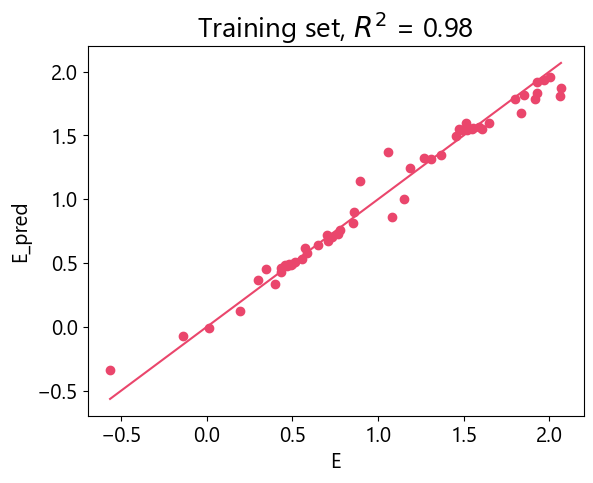

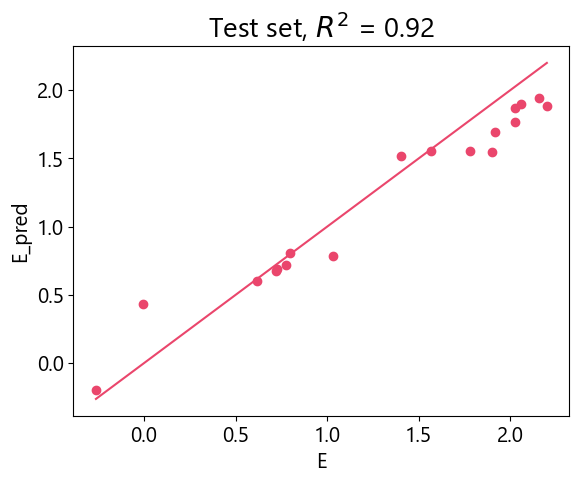

In [57]:
def find_rank(dictionary, key):
    target_value = dictionary[key]
    sorted_values = sorted(dictionary.values(), reverse=True)
    rank = sorted_values.index(target_value) + 1
    return rank

def calculate_r_squared(y_true, y_pred):
    mean_y = np.mean(y_true)
    ssr = np.sum((y_pred - y_true) ** 2)
    sst = np.sum((y_true - mean_y) ** 2)
    r_squared = 1 - (ssr / sst)
    return r_squared

def plot_parity(y_true, y_pred, title, R2):
    plt.scatter(y_true, y_pred, color=colors[0])
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color=colors[2])
    plt.title(f'{title}, $R^2$ = {R2:.2f}', fontproperties=title_font_style)
    plt.xticks(fontproperties=tick_font_style)
    plt.yticks(fontproperties=tick_font_style)
    plt.xlabel('E', fontproperties=label_font_style)
    plt.ylabel('E_pred', fontproperties=label_font_style)
    plt.show()
    plt.close()

# Calculate R2 for training and test sets
R2_train = calculate_r_squared(y_train, predict_rf_train)
R2_test = calculate_r_squared(y_test, predict_rf)

# Plot parity plot for training set
plot_parity(y_train, predict_rf_train, 'Training set', R2_train)

# Plot parity plot for test set
plot_parity(y_test, predict_rf, 'Test set', R2_test)


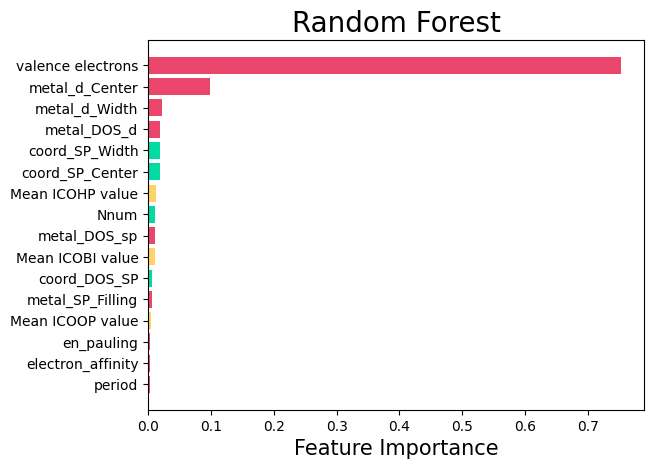

In [81]:
sort = best_rf.feature_importances_.argsort()
sorted_colors = [feature_colors[name] for name in selected_feature_names[sort]]

plt.barh(selected_feature_names[sort], best_rf.feature_importances_[sort], color = sorted_colors)

plt.title('Random Forest', fontsize=fs)
plt.xlabel("Feature Importance", fontsize=fss)
plt.savefig('./RF.png', bbox_inches = 'tight')

#### Permutation도 보기

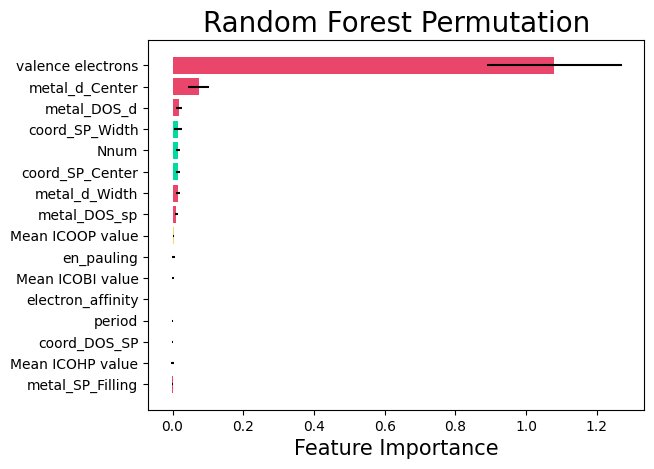

In [82]:
perm_importance_result_test = permutation_importance(best_rf, x_test, y_test, n_repeats=10)
plot_feature_importances(perm_importance_result_test, x_test.columns)
plt.title('Random Forest Permutation', fontsize=fs)
plt.xlabel("Feature Importance", fontsize=fss)
plt.savefig('./RF_permu.png', bbox_inches = 'tight')


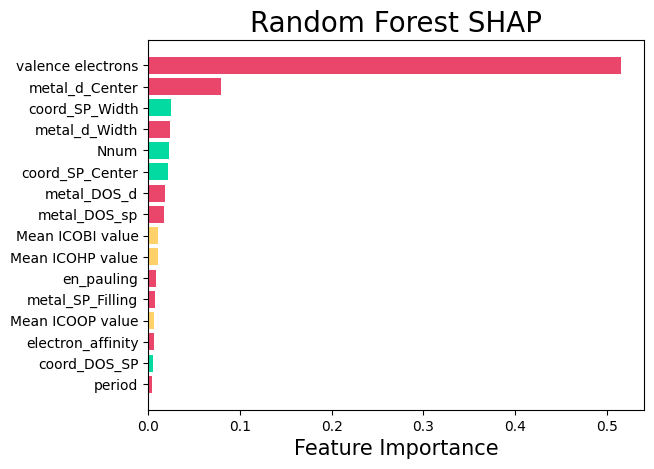

In [83]:
X_test_df = pd.DataFrame(x_test, columns=column_names[:x_test.shape[1]])

explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(x_test)
# Calculate the average SHAP values
avg_shap_values = np.abs(shap_values).mean(axis=0)

# Get the sort order
sort = np.argsort(avg_shap_values)

# Sort the feature names and colors
sorted_names = X_test_df.columns[sort]
sorted_colors = [feature_colors[name] for name in sorted_names]

# Generate the bar plot
plt.barh(sorted_names, avg_shap_values[sort], color=sorted_colors)

# Set the title and labels
plt.title('Random Forest SHAP', fontsize=fs)
plt.xlabel("Feature Importance", fontsize=fss)

# Save the plot
plt.savefig('./RF_shap.png', bbox_inches = 'tight')

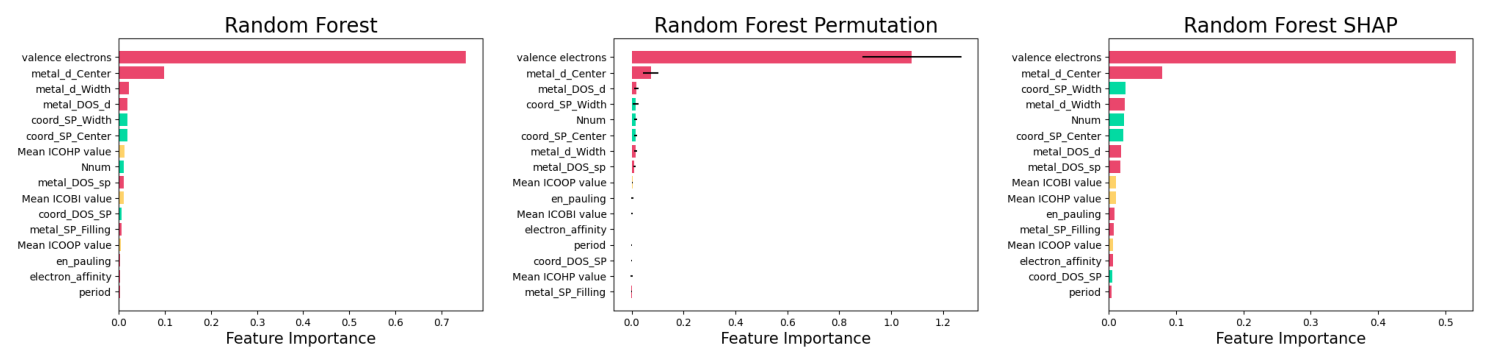

In [87]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read the images
img1 = mpimg.imread('./RF.png') 
img2 = mpimg.imread('./RF_permu.png')
img3 = mpimg.imread('./RF_shap.png')

# Create the subplot
fig, axs = plt.subplots(1, 3, figsize=(15,5))  # Adjust the figure size as needed

# Show the images
axs[0].imshow(img1)
axs[0].axis('off')

axs[1].imshow(img2)
axs[1].axis('off')

axs[2].imshow(img3)
axs[2].axis('off')

# Display the plot
plt.subplots_adjust(wspace=0.05)
plt.savefig('./combined_RF_plots.png', bbox_inches='tight',dpi=300)

plt.tight_layout()
plt.show()


### 4. XGBoost 기반 Feature importance

In [30]:
params_xgb = {
    'n_estimators': randint(100, 1000),
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 2, 3, 4, 5],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1],
}

In [31]:
xgb = XGBRegressor()
xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = params_xgb, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1, scoring='neg_mean_squared_error')
xgb_random.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1],
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.3],
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'min_child_weight': [1, 2, 3, 4, 5],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f1a16f3b7f0>,
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [32]:
# 최적의 모델 및 파라미터 출력
print("Best Estimator:", xgb_random.best_params_)

print('Score on training set:', xgb_random.best_estimator_.score(x_train, y_train))
print('Score on test set:', xgb_random.best_estimator_.score(x_test, y_test))

best_xgb = xgb_random.best_estimator_

Best Estimator: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 868, 'subsample': 1}
Score on training set: 0.9999986915823311
Score on test set: 0.9188785144089978


In [33]:
predict_xgb_train = best_xgb.predict(x_train) # 최고의 개수로 학습한 거에 x_train을 넣은 결과
predict_xgb = best_xgb.predict(x_test) # 최고의 개수로 학습한 거에 x_test를 넣은 결과

mse_xgb_train = mean_squared_error(y_train, predict_xgb_train) # rdf에서 train set 에러
mse_xgb_test = mean_squared_error(y_test, predict_xgb) # rdf에서 test set 에러

print(mse_xgb_train)
print(mse_xgb_test)

5.341274390489374e-07
0.04558117122622054


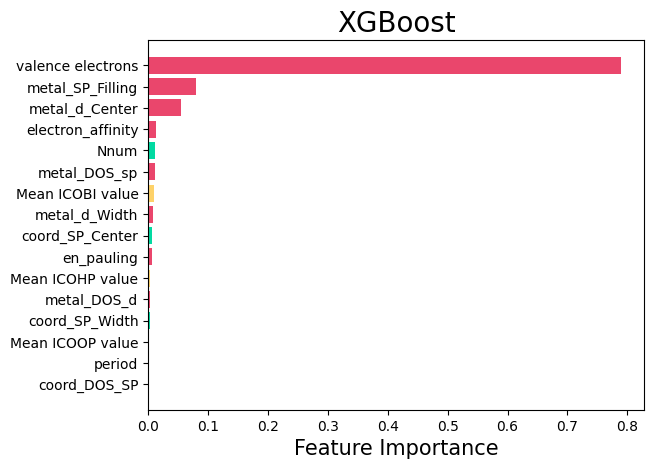

In [89]:
sort = best_xgb.feature_importances_.argsort()
sorted_colors = [feature_colors[name] for name in selected_feature_names[sort]]

plt.barh(selected_feature_names[sort], best_xgb.feature_importances_[sort], color=sorted_colors)
plt.title('XGBoost', fontsize=fs)
plt.xlabel("Feature Importance", fontsize=fss)
plt.savefig('./XGBoost.png', bbox_inches = 'tight')

#### Permutation도 보기

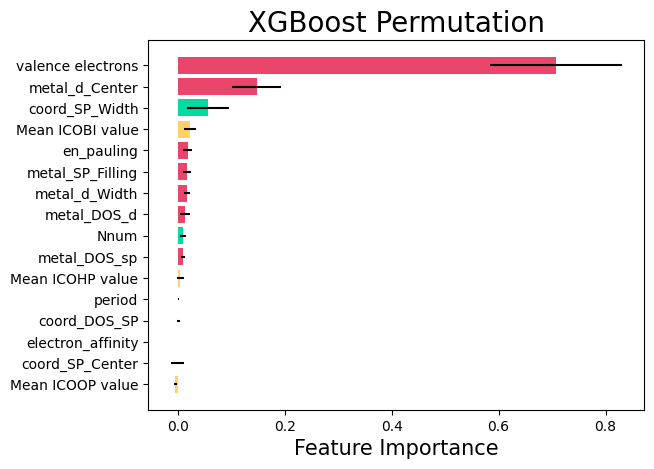

In [90]:
perm_importance_result_train = permutation_importance(best_xgb, x_test, y_test, n_repeats=10)
plot_feature_importances(perm_importance_result_train, x_train.columns)
plt.title('XGBoost Permutation', fontsize=fs)
plt.xlabel("Feature Importance", fontsize=fss)
plt.savefig('./XGBoost_permu.png', bbox_inches = 'tight')

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


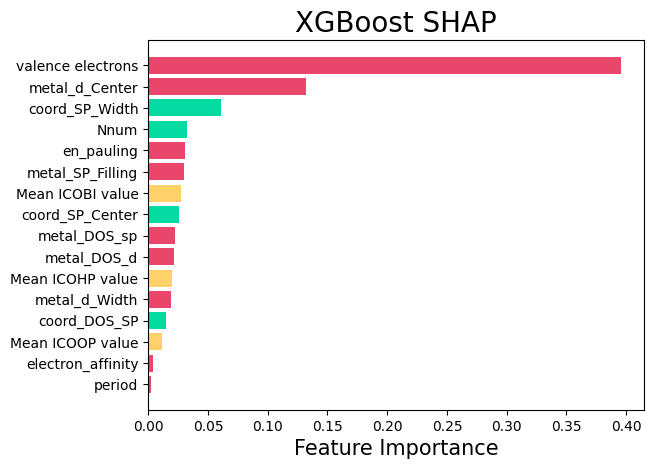

In [91]:
X_test_df = pd.DataFrame(x_test, columns=column_names[:x_test.shape[1]])

explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(x_test)
avg_shap_values = np.abs(shap_values).mean(axis=0)

# Calculate the average SHAP values
avg_shap_values = np.abs(shap_values).mean(axis=0)

# Get the sort order
sort = np.argsort(avg_shap_values)

# Sort the feature names and colors
sorted_names = X_test_df.columns[sort]
sorted_colors = [feature_colors[name] for name in sorted_names]

# Generate the bar plot
plt.barh(sorted_names, avg_shap_values[sort], color=sorted_colors)

# Set the title and labels
plt.xlabel("Feature Importance", fontsize=fss)
plt.title('XGBoost SHAP', fontsize=fs)
plt.savefig('./XGBoost_shap.png', bbox_inches = 'tight')


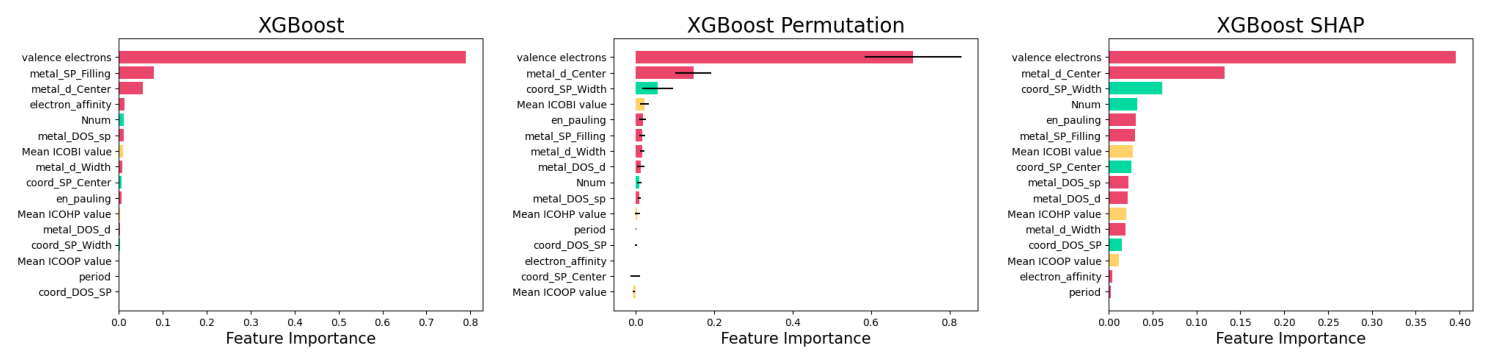

In [92]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read the images
img1 = mpimg.imread('./XGBoost.png') 
img2 = mpimg.imread('./XGBoost_permu.png')
img3 = mpimg.imread('./XGBoost_shap.png')

# Create the subplot
fig, axs = plt.subplots(1, 3, figsize=(15,5))  # Adjust the figure size as needed

# Show the images
axs[0].imshow(img1)
axs[0].axis('off')

axs[1].imshow(img2)
axs[1].axis('off')

axs[2].imshow(img3)
axs[2].axis('off')

# Display the plot
plt.subplots_adjust(wspace=0.05)
plt.savefig('./combined_XG_plots.png', bbox_inches='tight',dpi=300)
plt.tight_layout()
plt.show()


# 상관계수 분석

In [37]:
'''import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read the images
img1 = mpimg.imread('./Lasso.png') 
img2 = mpimg.imread('./Ridge.png')
img3 = mpimg.imread('./RF.png')
img4 = mpimg.imread('./XGBoost.png')

# Create the subplot
fig, axs = plt.subplots(2, 2, figsize=(16,10))

# Show the images
axs[0, 0].imshow(img1)
axs[0, 0].axis('off')

axs[0, 1].imshow(img2)
axs[0, 1].axis('off')

axs[1, 0].imshow(img3)
axs[1, 0].axis('off')

axs[1, 1].imshow(img4)
axs[1, 1].axis('off')

print(selected_feature_names)
# Display the plot
plt.subplots_adjust(hspace=0.8,wspace=0.6)
plt.tight_layout()
plt.show()
'''

"import matplotlib.pyplot as plt\nimport matplotlib.image as mpimg\n\n# Read the images\nimg1 = mpimg.imread('./Lasso.png') \nimg2 = mpimg.imread('./Ridge.png')\nimg3 = mpimg.imread('./RF.png')\nimg4 = mpimg.imread('./XGBoost.png')\n\n# Create the subplot\nfig, axs = plt.subplots(2, 2, figsize=(16,10))\n\n# Show the images\naxs[0, 0].imshow(img1)\naxs[0, 0].axis('off')\n\naxs[0, 1].imshow(img2)\naxs[0, 1].axis('off')\n\naxs[1, 0].imshow(img3)\naxs[1, 0].axis('off')\n\naxs[1, 1].imshow(img4)\naxs[1, 1].axis('off')\n\nprint(selected_feature_names)\n# Display the plot\nplt.subplots_adjust(hspace=0.8,wspace=0.6)\nplt.tight_layout()\nplt.show()\n"

# PCA 분석

#### G_Cl 미포함

The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.


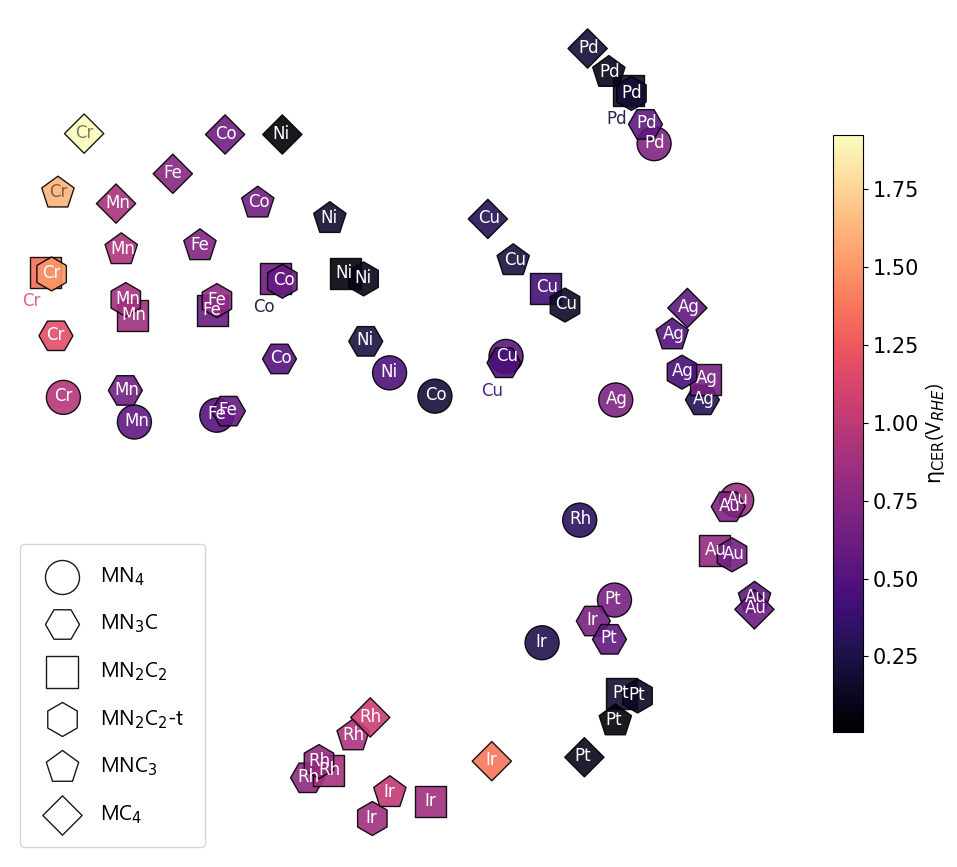

In [52]:
from sklearn.manifold import TSNE
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
import numpy as np

big=600
size=[big, big, big*5/6, big, big, big*2/3]
num_N = [4, 3, 2, 5, 1, 0]

# TSNE transformation
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(x_scaled)

# scatter plot
plt.figure(figsize=(11, 11))

# Color map
cmap = plt.cm.magma

# Calculate overpotential
overpotential = np.abs(df['G(Cl)'] - 1.36)

# Normalize overpotential
normalize = mcolors.Normalize(vmin=np.min(overpotential), vmax=np.max(overpotential))
colorss=[]
# plot each class with its own marker and color
for i in range(len(num_N)):
    is_N = df2['index'] == num_N[i]
    X_tsne_sub = X_tsne[is_N]
    colorss = [cmap(normalize(value)) for value in overpotential[is_N]]
    plt.scatter(X_tsne_sub[:, 0], X_tsne_sub[:, 1], s=size[i], color=colorss, marker=sym[i], alpha=0.9, label=labels[i], edgecolors=(0, 0, 0, 0.9))

annotate_config = {
    ('Cr', 0): {'offset': (-0.095, -0.048), 'color': 'black', 'alpha': 0.5},
    ('Cr', 1): {'offset': (-0.095, -0.048), 'color': 'black', 'alpha': 0.5},
    ('Ir', None): {'offset': (-0.075, -0.048), 'color': 'white', 'alpha': 1},
    ('Mn', None): {'offset': (-0.115, -0.048), 'color': 'white', 'alpha': 1},
    ('Rh', None): {'offset': (-0.115, -0.048), 'color': 'white', 'alpha': 1},
    ('Pd', 2): {'offset': (-0.25, -0.39), 'color': 'normalized', 'alpha': 0.9, 'value': 0.2},
    ('Co', 2): {'offset': (-0.25, -0.39), 'color': 'normalized', 'alpha': 0.9, 'value': 0.2},
    ('Cr', 2): {'offset': (-0.25, -0.39), 'color': 'normalized', 'alpha': 0.9, 'value': 1.2},
    ('Cu', 3): {'offset': (-0.25, -0.39), 'color': 'normalized', 'alpha': 0.9, 'value': 0.4},
}

for i, (m, nnum) in enumerate(zip(df2['M'], df2['index'])):
    config = annotate_config.get((m, nnum)) or annotate_config.get((m, None)) or {'offset': (-0.105, -0.048), 'color': 'white', 'alpha': 1}
    x, y = X_tsne[i, 0] + config['offset'][0], X_tsne[i, 1] + config['offset'][1]
    color = cmap(normalize(config['value'])) if config['color'] == 'normalized' else config['color']
    plt.text(x, y, f'{m}', fontsize=12, color=color, alpha=config.get('alpha', 1), fontproperties=label_font_style.set_weight('bold'))

# Labels and title
plt.axis('off')

# Legend
legend = plt.legend(loc='lower left', borderpad=1, labelspacing=1.2, prop=label_font_style)
for handle in legend.legendHandles:
    handle.set_color('white')
    handle.set_edgecolor('black')
    handle.set_linewidth(1)

# Adding colorbar
scalarmappaple = plt.cm.ScalarMappable(norm=normalize, cmap=cmap)
scalarmappaple.set_array(overpotential)
cbar = plt.colorbar(scalarmappaple, fraction=0.035, pad=0.05)
cbar.ax.tick_params(labelsize=fss)
cbar.set_label('$\mathrm{η_{CER}}$'+'(V$_{RHE}$)', fontproperties=label_font_style)

# Save and display the plot
plt.savefig('tSNE_plot.png', dpi=300)
plt.show()


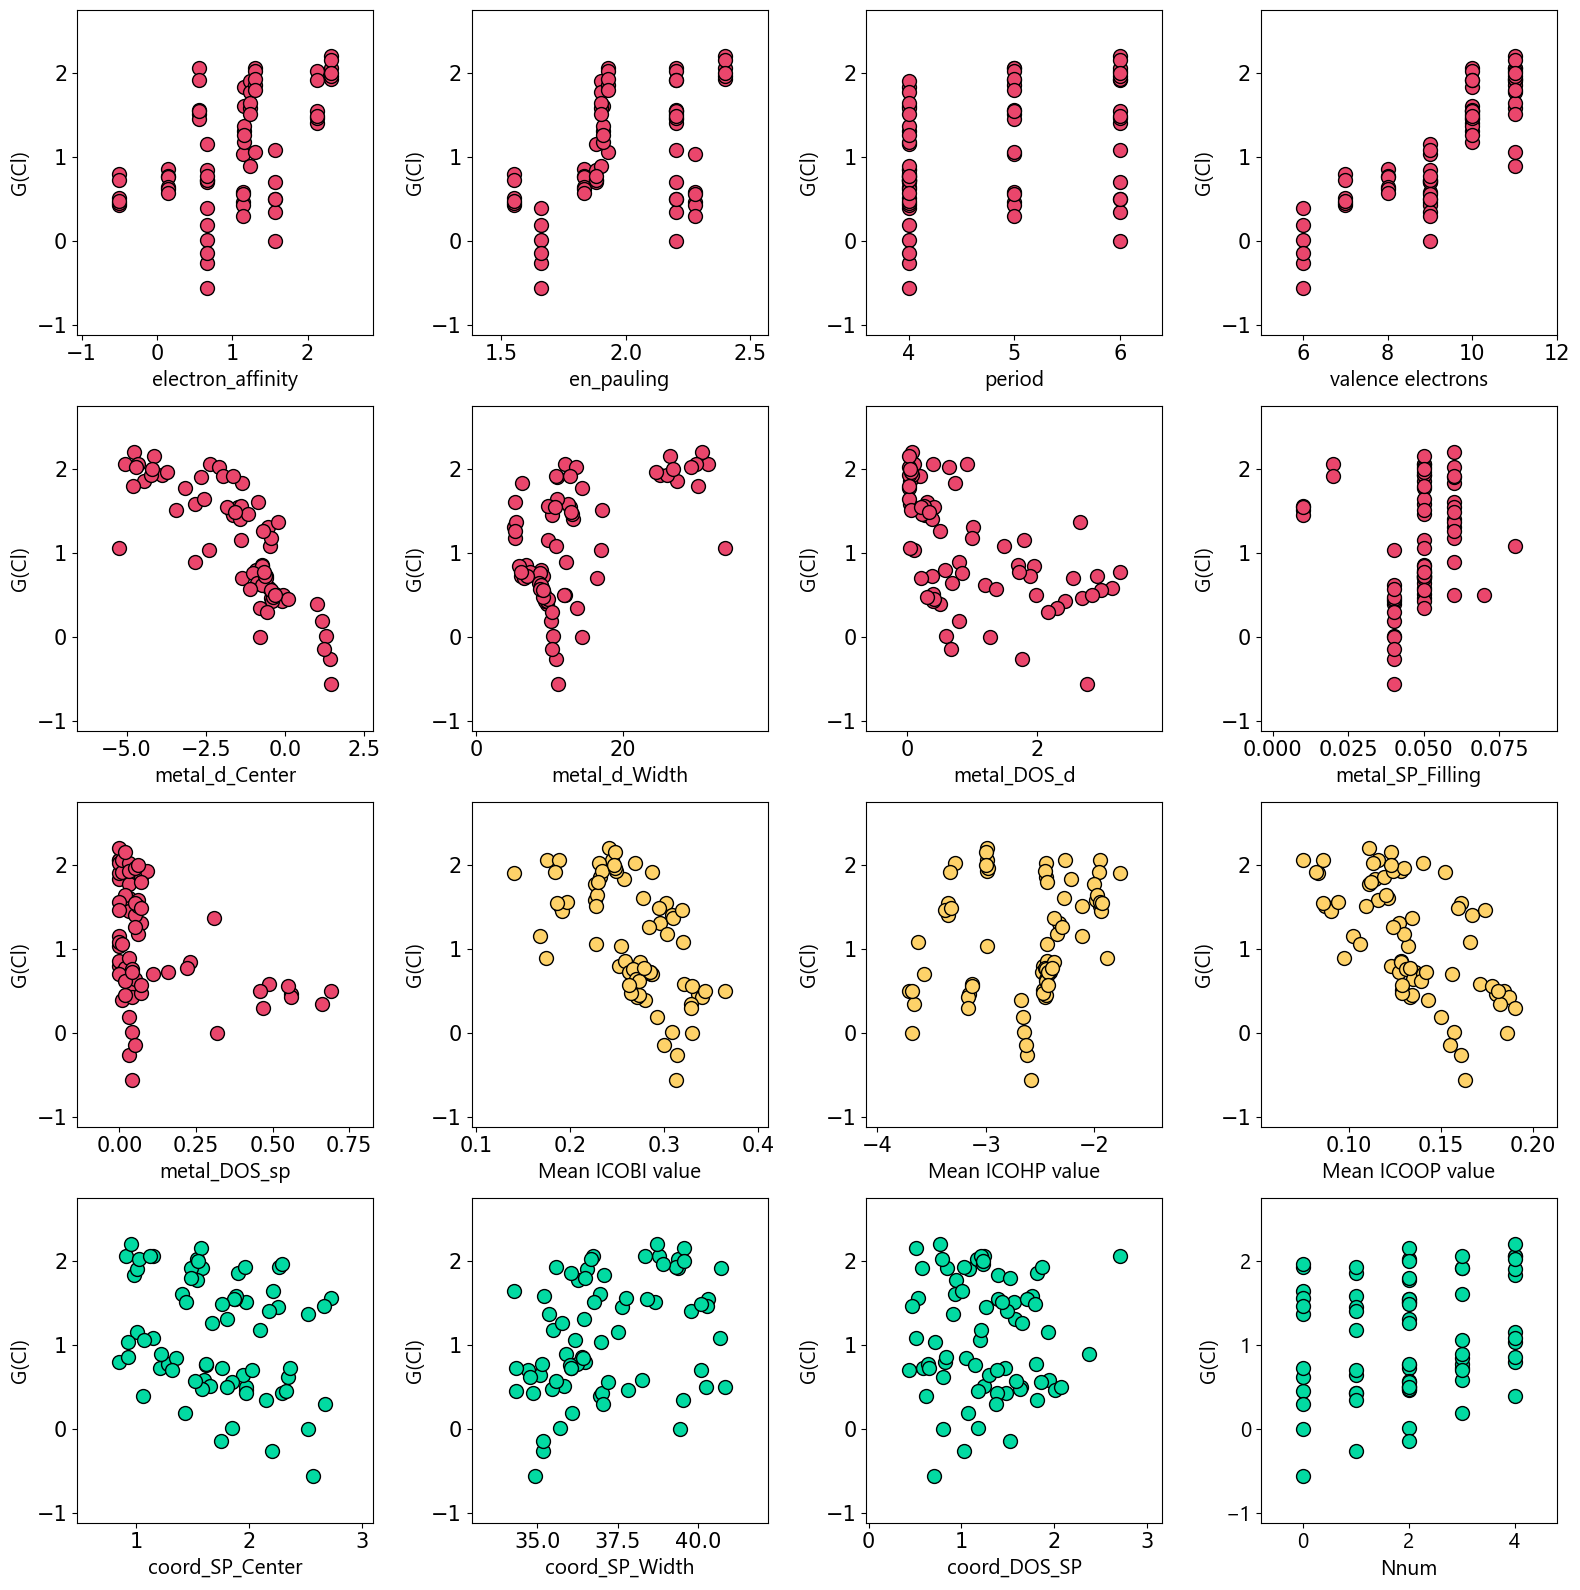

In [76]:
def plot_parity(ax, y_true, y_pred, title, i):
    ax.scatter(y_pred, y_true, color=colors[i], edgecolor='black', s=100)
    ax.tick_params(labelsize=label_font_style.get_size())
    ax.set_xlabel(title, fontproperties=label_font_style)
    ax.set_ylabel('G(Cl)', fontproperties=label_font_style)

    # Calculate the range of data
    x_range = y_pred.max() - y_pred.min()
    y_range = y_true.max() - y_true.min()

    # Add/subtract 10% of the range to/from the max/min
    ax.set_xlim(y_pred.min() - 0.2 * x_range, y_pred.max() + 0.2 * x_range)
    ax.set_ylim(y_true.min() - 0.2 * y_range, y_true.max() + 0.2 * y_range)


# calculate the number of rows needed for subplots
n = len(selected_feature_names)
ncols = 4  # number of columns in the subplot grid
nrows = n // ncols if n % ncols == 0 else n // ncols + 1

fig, axes = plt.subplots(nrows, ncols, figsize=(16, nrows * 4))  # adjust the size as needed
axes = axes.ravel()  # to iterate over axes easily
plt.xticks(fontproperties=tick_font_style)
plt.yticks(fontproperties=tick_font_style)
for i, feature_name in enumerate(selected_feature_names):
    plot_parity(axes[i], y, X[feature_name], feature_name,i)

# if there are less features than total subplots, remove empty ones
if n < ncols * nrows:
    for i in range(n, ncols * nrows):
        fig.delaxes(axes[i])

plt.subplots_adjust(hspace=0.5, wspace=10000)

plt.tight_layout()  # adjust layout so labels don't overlap

plt.savefig('./featurevsgcl.png', bbox_inches = 'tight', dpi=300)

plt.show()


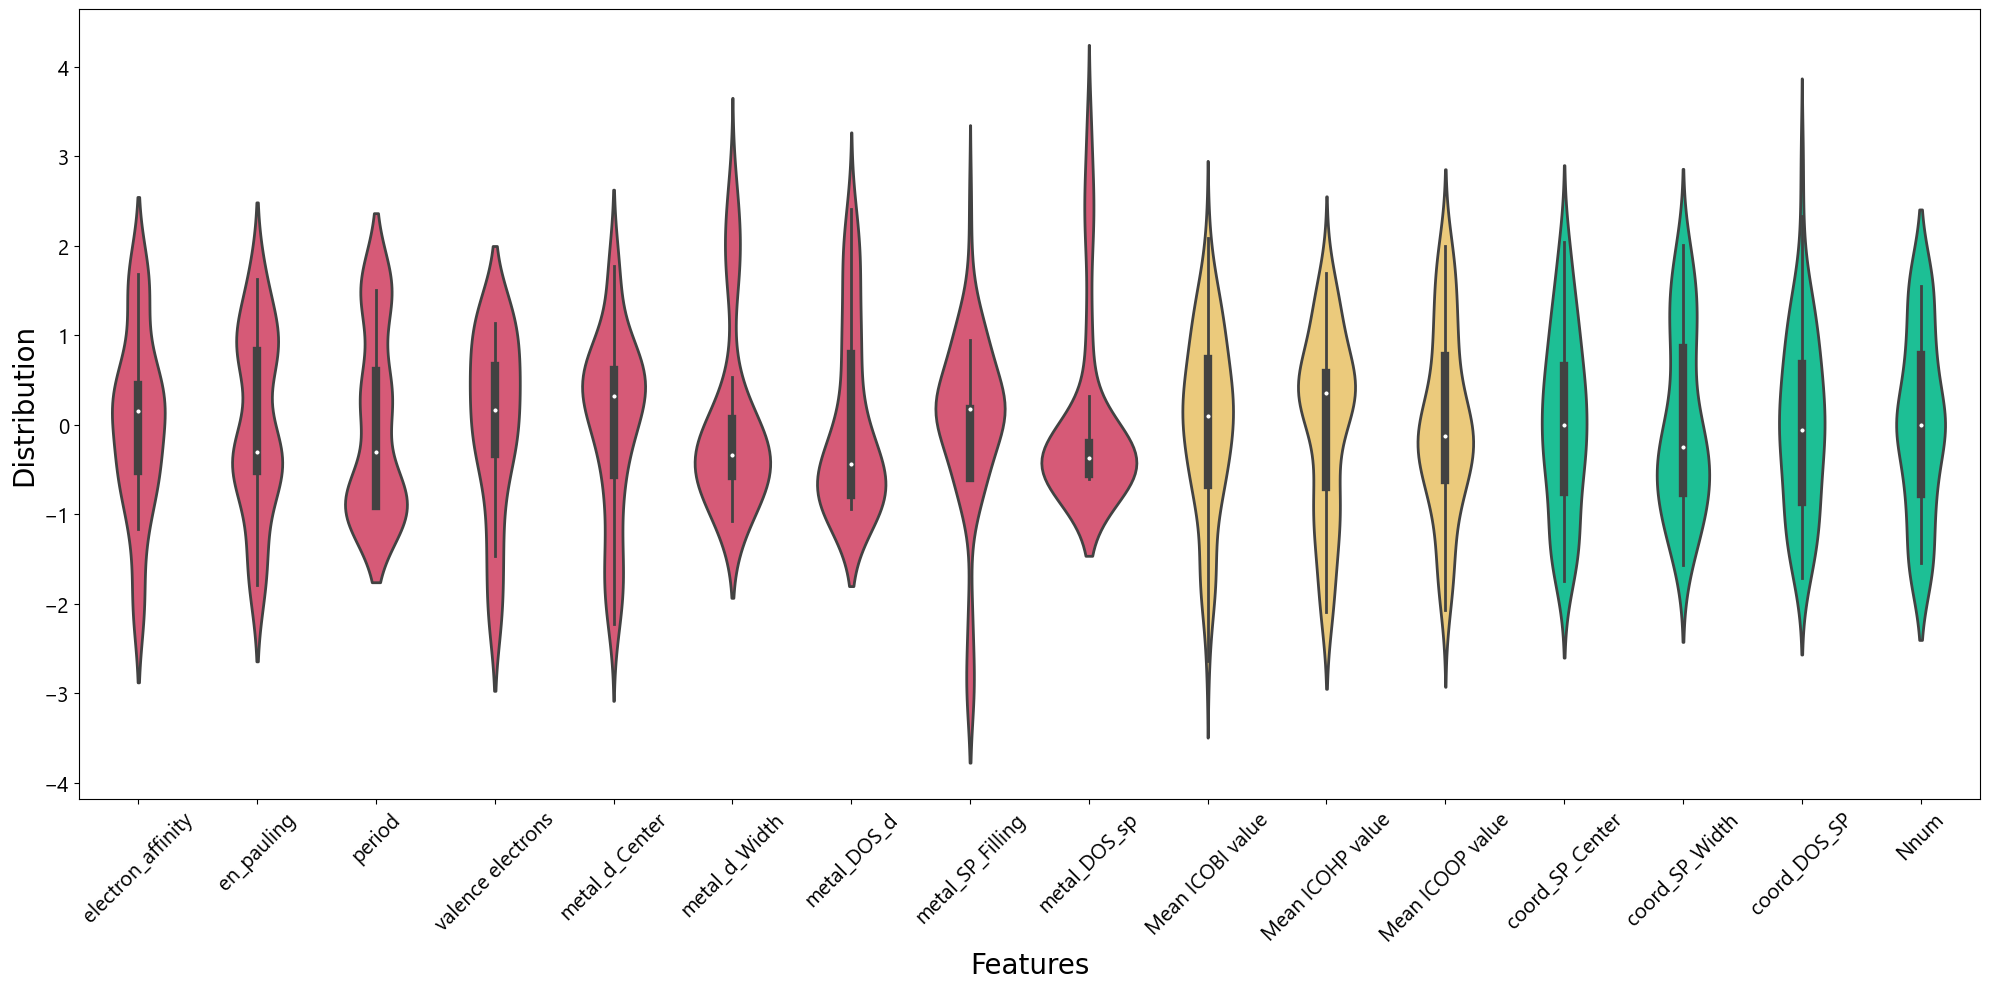

In [80]:
# Set larger figure size
plt.figure(figsize=(20, 10))

# Plot a violinplot for each feature on the same figure
sns.violinplot(data=x_scaled_df, palette=colors, linewidth=2)


plt.xlabel('Features', fontsize=20)
plt.ylabel('Distribution', fontsize=20)

# Rotate x labels for better readability if there are many features
plt.xticks(rotation=45, fontsize=15, fontproperties=tick_font_style)  # Uses custom tick_font_style
plt.yticks(fontsize=15, fontproperties=tick_font_style)  # Uses custom tick_font_style

# Remove grid
plt.grid(False)

# Show the plot with a tight layout
plt.tight_layout()

# Save the plot
plt.savefig('./violin.png', bbox_inches = 'tight', dpi=300)

# Display the plot
plt.show()

